# First: I need to prepare my data
# USE ONLY TRAIN DATA!!!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.arima import ARIMA

from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape
from statistics import mean, median

In [2]:
time_series = pd.read_csv("selected_columns.csv", index_col=0, parse_dates=True)

In [3]:
time_series.head()

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual
date,,,
2015-01-01 08:00:00,64277.0,385.0,1936.0
2015-01-01 09:00:00,65100.0,1053.0,1927.0
2015-01-01 10:00:00,65875.0,1635.0,1846.0
2015-01-01 11:00:00,67460.0,1883.0,1768.0
2015-01-01 12:00:00,65706.0,1857.0,1715.0


In [4]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50391 entries, 2015-01-01 08:00:00 to 2020-09-30 22:00:00
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   FR_load_actual_entsoe_transparency  50391 non-null  float64
 1   FR_solar_generation_actual          50391 non-null  float64
 2   FR_wind_onshore_generation_actual   50391 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [87]:
# Extract year and month from the index
time_series.loc[:, 'DayOfWeek'] = time_series.index.dayofweek
time_series.loc[:, 'DayOfMonth'] = time_series.index.day
time_series.loc[:, 'Year'] = time_series.index.year
time_series.loc[:, 'Month'] = time_series.index.month
time_series['HourOfDay'] = time_series.index.hour
time_series['WeekOfYear'] = time_series.index.isocalendar().week

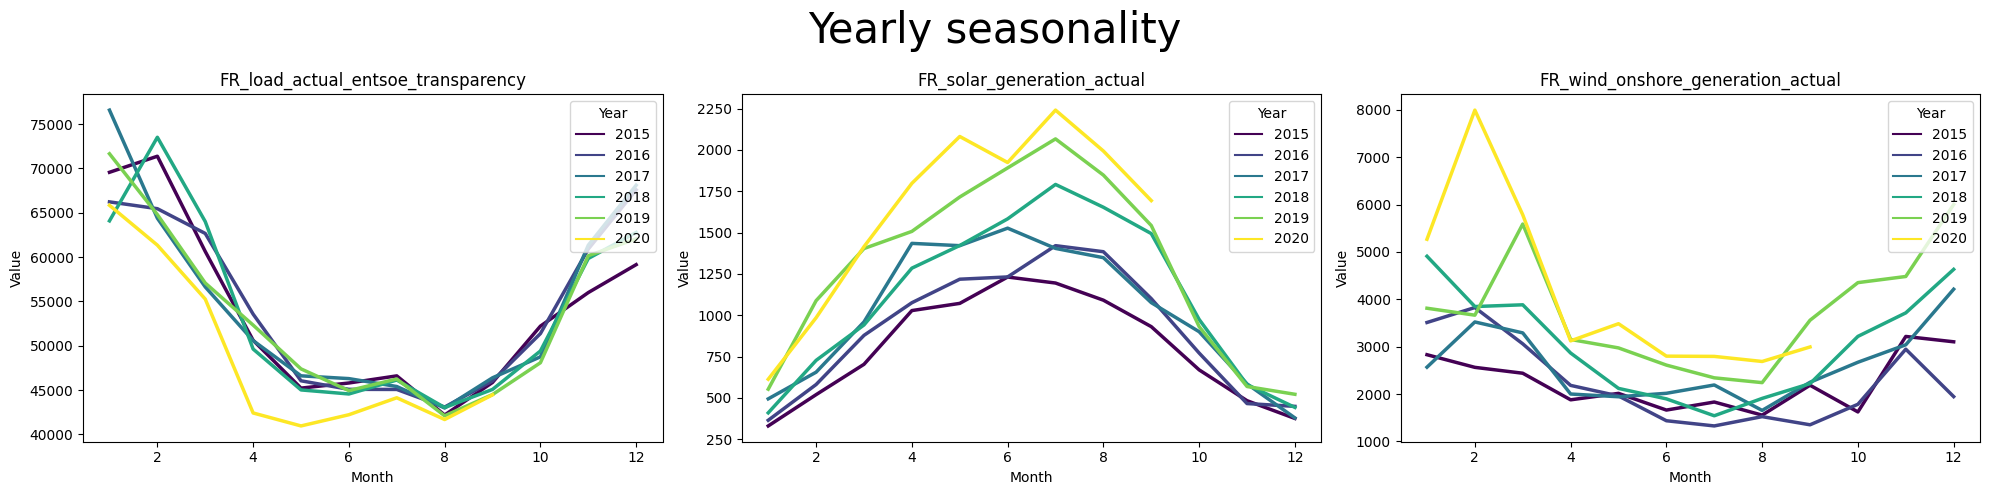

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_seasonality(data, frequency='Month', 
                     hue='Year', title=None):
    """
    Plots the seasonality of the time series.

    Args:
        data (pandas.DataFrame): The time series to plot.
        frequency (str): The frequency of the time series (default: 'Month').
        hue (str): Sunsets of the data (default: 'Year').
        title (str): The title of the plot (default: None).
    """
    num_cols = 3
    num_rows = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < len(time_series.columns):
            col = time_series.columns[i]
            sns.lineplot(ax=ax, data=data, x=frequency, y=col, 
                         hue=hue, palette='viridis', errorbar=None,
                         linewidth=2.5, markers=True)
            ax.set_title(f'{col}')
            ax.set_xlabel(frequency)
            ax.set_ylabel('Value')
            ax.legend(title=hue, loc = 'upper right')
            
        else:
            ax.axis('off')  

    fig.suptitle(title, fontsize=30)   
    plt.tight_layout()
    plt.show()

plot_seasonality(data = time_series, title='Yearly seasonality')


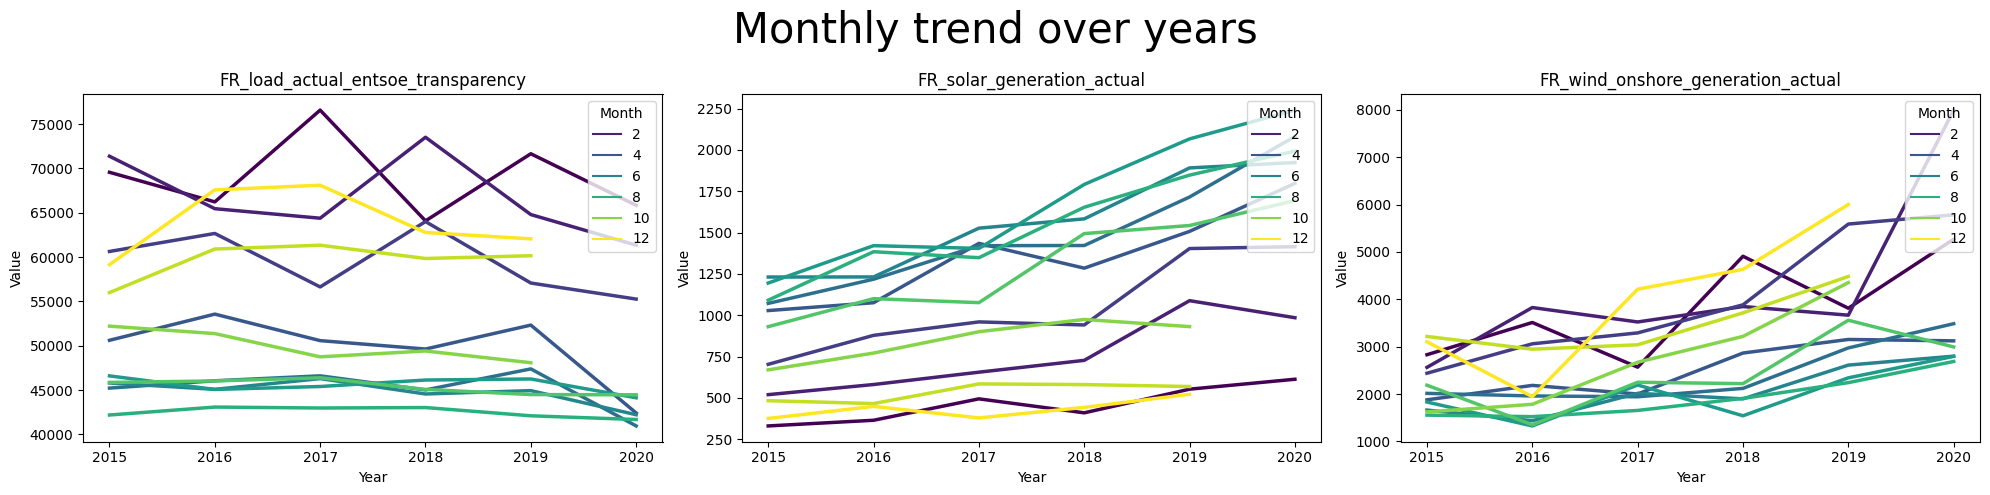

In [54]:
plot_seasonality(data = time_series, frequency='Year', hue='Month', title='Monthly trend over years')

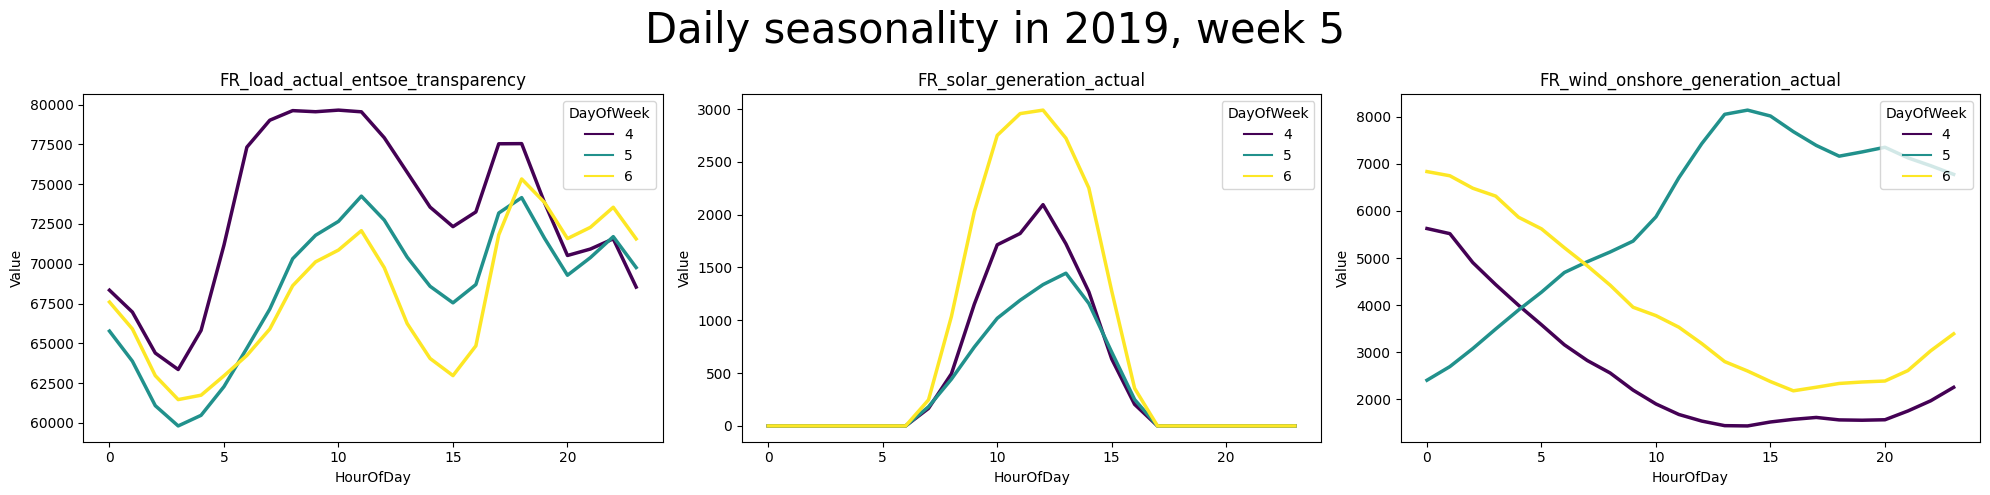

In [61]:
plot_seasonality(data=time_series[(time_series.index.year==2019) & 
                                  (time_series.index.month==2) & 
                                  (time_series.index.isocalendar().week==5)],
                 frequency='HourOfDay',
                 hue='DayOfWeek',
                 title = 'Daily seasonality in 2019, week 5')

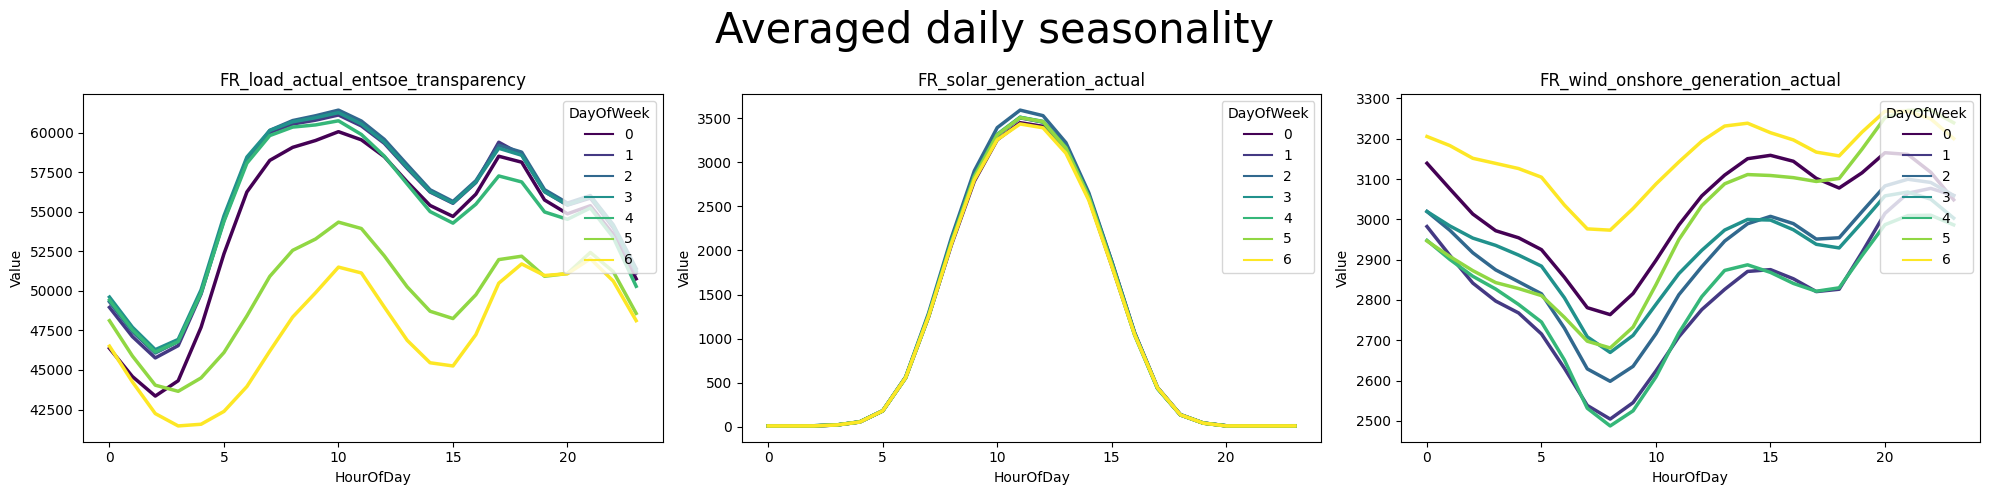

In [62]:
plot_seasonality(data=time_series,
                 frequency='HourOfDay',
                 hue='DayOfWeek',
                 title = 'Averaged daily seasonality')

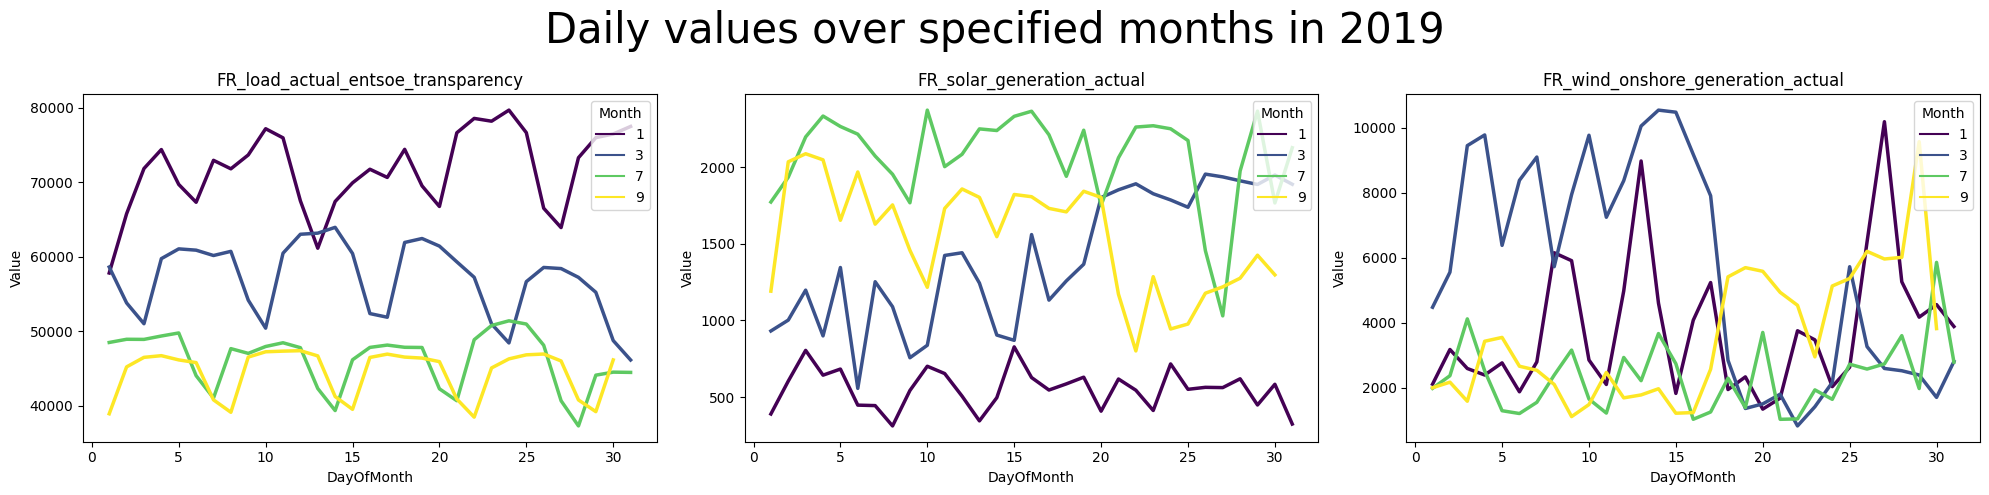

In [90]:
# Plot weekly seasonality for some months
# Only load has weekly seasonality

time_series_2019 = time_series[time_series.index.year == 2019]
desired_months = [1, 3, 7, 9]
time_series_desired_months = time_series_2019[time_series_2019.index.month.isin(desired_months)]

# Plot the seasonality for the desired months
plot_seasonality(data=time_series_desired_months, 
                 frequency='DayOfMonth', 
                 hue='Month',
                 title='Weekly seasonality over specified months in 2019')

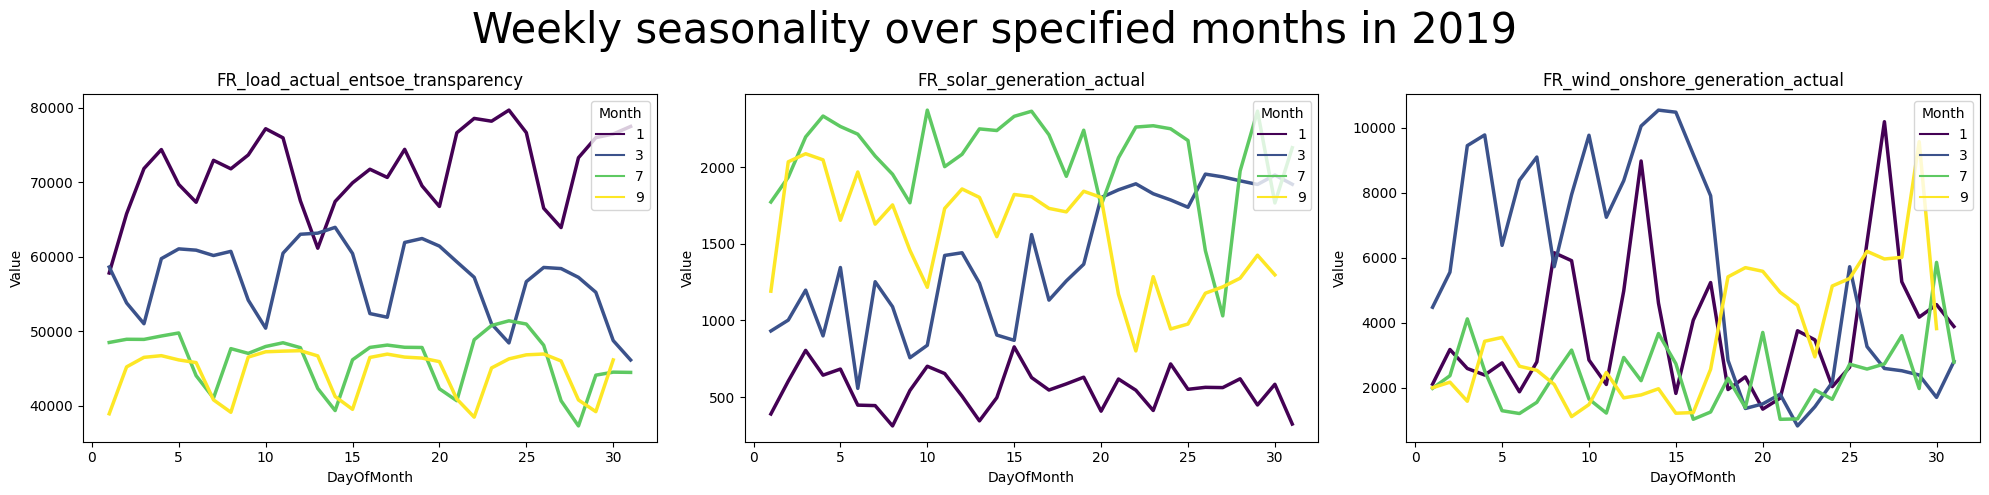

In [93]:
# Plot weekly seasonality for some months
# Only load has weekly seasonality

time_series_2019 = time_series[time_series.index.year == 2019]
desired_months = [1, 3, 7, 9]
time_series_desired_months = time_series_2019[time_series_2019.index.month.isin(desired_months)]

# Plot the seasonality for the desired months
plot_seasonality(data=time_series_desired_months, 
                 frequency='DayOfMonth', 
                 hue='Month',
                 title='Weekly seasonality over specified months in 2019')

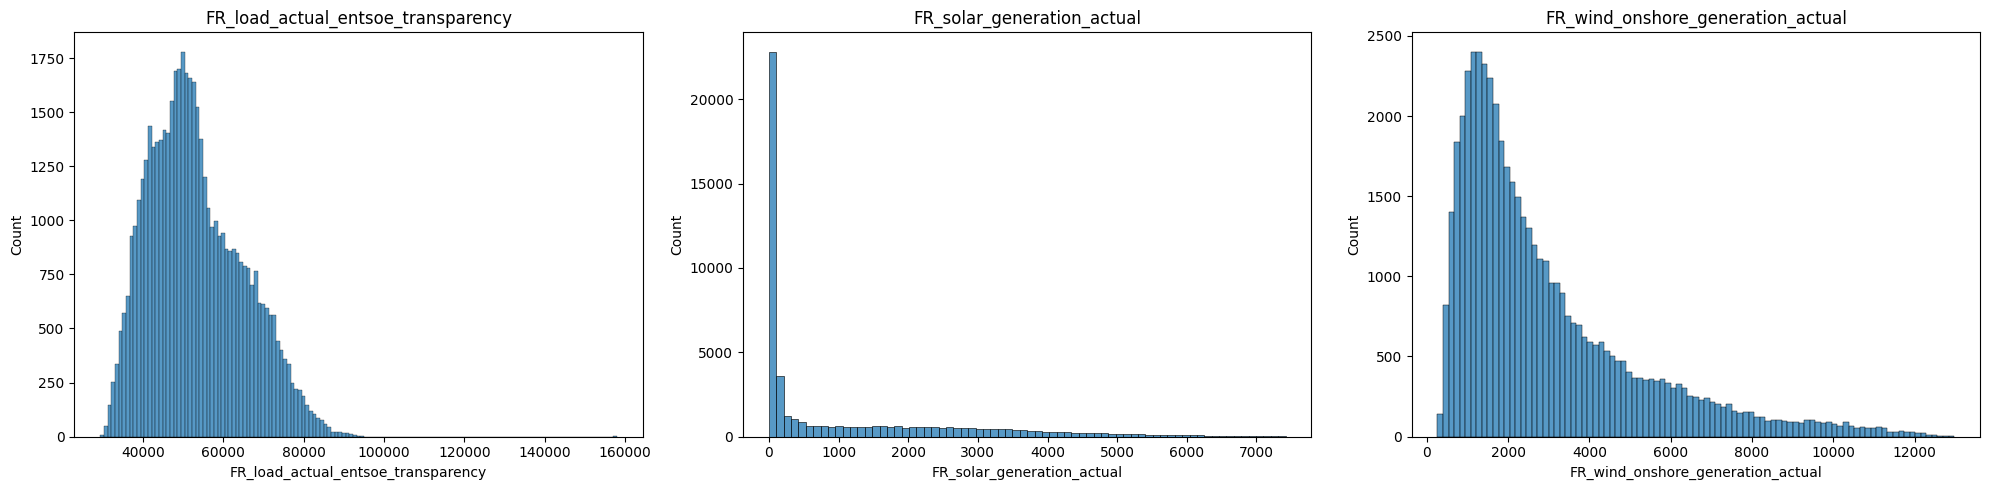

In [17]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.histplot(ax=ax, data=time_series, x=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

# Load - weekly and daily seasonality (repeating pattern: low at night, peaks at )

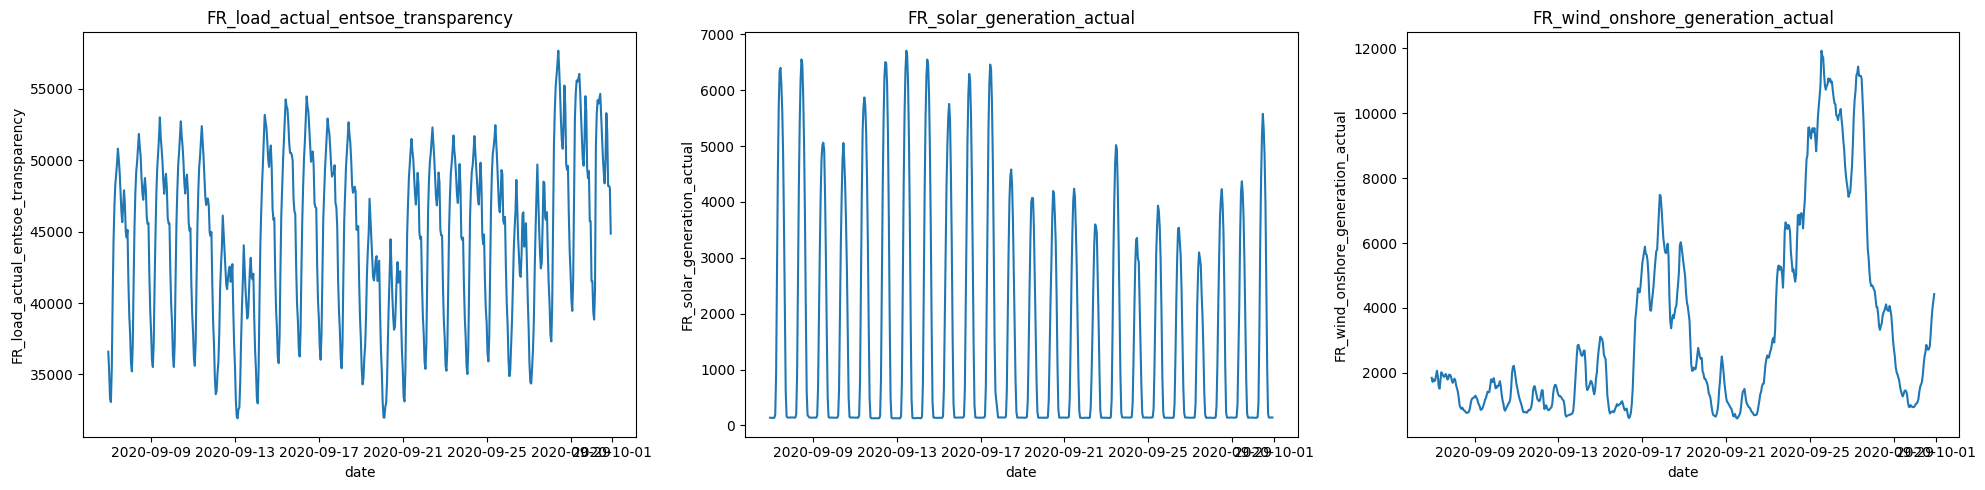

In [50]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.lineplot(ax=ax, data=time_series[-576:], x = time_series.index[-576:], y=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

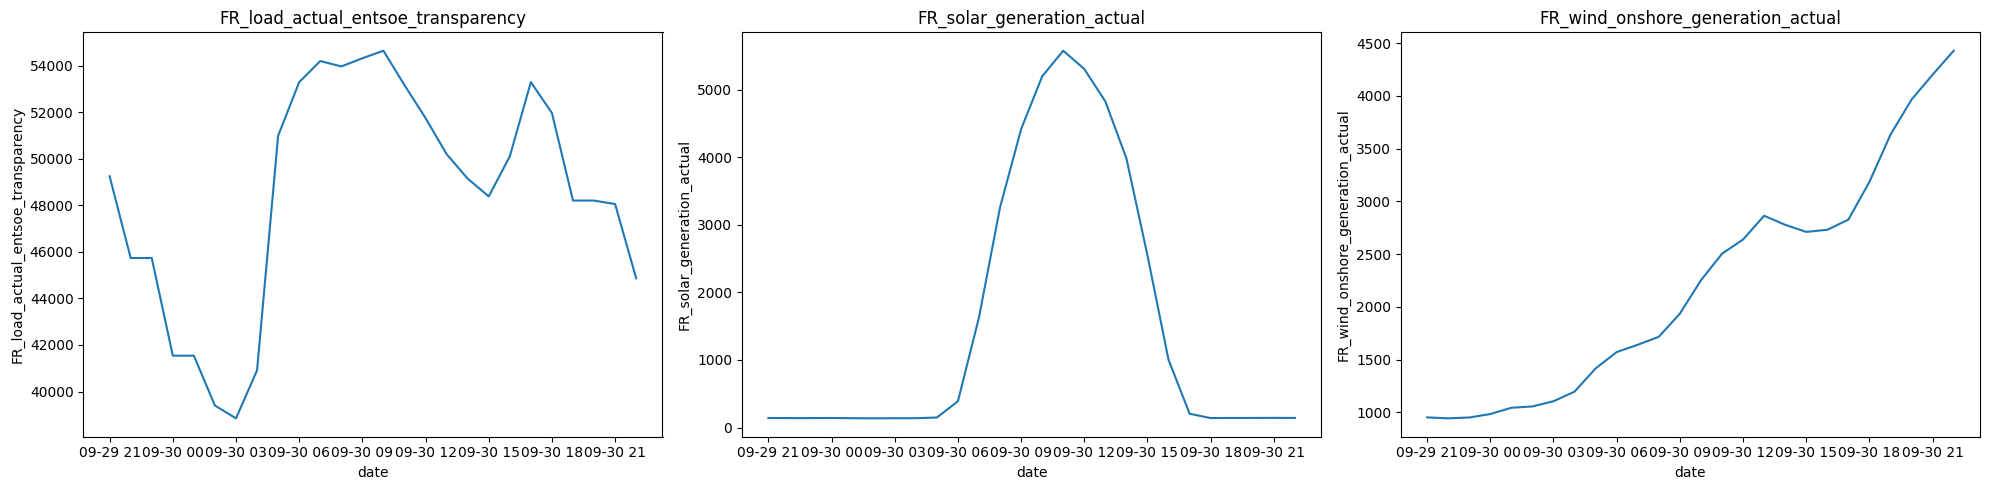

In [129]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.lineplot(ax=ax, data=time_series[-26:], x = time_series.index[-26:], y=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

# Clear yearly and daily seasonality

In [35]:
# https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html?highlight=kpss
from pmdarima.arima.utils import ndiffs, nsdiffs

def stationary_seasonal(time_series, column_name):
    
    adf_diff = ndiffs(time_series[column_name], test='adf')
    kpss_diff = ndiffs(time_series[column_name], test='kpss')
    pp_diff = ndiffs(time_series[column_name], test='pp')
    
    if adf_diff == 0 and kpss_diff == 0 and pp_diff == 0:
         print('Is stationary')
    else: 
        print('Is not stationary')

    if adf_diff > 0 or kpss_diff > 0:
        ocsb_diff = nsdiffs(time_series[column_name], test='ocsb', m=24)
        ch_diff = nsdiffs(time_series[column_name], test='ch', m=24)
        if ocsb_diff == 0 and ch_diff==0:
            print('Does not require seasonal differencing')
        else:
            print('Requires seasonal differencing')
            
for col in time_series.columns[:3]:
    print(col, ':')
    stationary_seasonal(time_series, col)

FR_load_actual_entsoe_transparency :
Is not stationary
Requires seasonal differencing
FR_solar_generation_actual :
Is not stationary
Requires seasonal differencing
FR_wind_onshore_generation_actual :
Is not stationary
Does not require seasonal differencing


In [163]:
train_ts = time_series[-600:-24]
test_ts = time_series[-24:]

In [95]:
train_ts = time_series[-200:-24]
train_ts

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,Day,Year,Month,HourOfDay,DayOfWeek,WeekOfYear,DayOfMonth
date,,,,,,,,,,
2020-09-22 15:00:00,46847.0,1913.0,1342.0,2020,2020,9,15,1,39,22
2020-09-22 16:00:00,47706.0,1004.0,1425.0,2020,2020,9,16,1,39,22
2020-09-22 17:00:00,49147.0,267.0,1592.0,2020,2020,9,17,1,39,22
2020-09-22 18:00:00,48452.0,138.0,1662.0,2020,2020,9,18,1,39,22
2020-09-22 19:00:00,45155.0,137.0,1672.0,2020,2020,9,19,1,39,22
...,...,...,...,...,...,...,...,...,...,...
2020-09-29 18:00:00,53429.0,140.0,944.0,2020,2020,9,18,1,40,29
2020-09-29 19:00:00,49462.0,138.0,1009.0,2020,2020,9,19,1,40,29
2020-09-29 20:00:00,48742.0,140.0,976.0,2020,2020,9,20,1,40,29


In [99]:
test_ts = time_series[-24:]
test_ts_exog = test_ts[['HourOfDay', 'DayOfWeek']]

In [96]:
train_ts.columns
# 'HourOfDay', 'DayOfWeek'

Index(['FR_load_actual_entsoe_transparency', 'FR_solar_generation_actual',
       'FR_wind_onshore_generation_actual', 'Day', 'Year', 'Month',
       'HourOfDay', 'DayOfWeek', 'WeekOfYear', 'DayOfMonth'],
      dtype='object')

# With exogenous

In [97]:
model = auto_arima(train_ts.iloc[:,0], exogenous=train_ts[['HourOfDay', 'DayOfWeek']], stepwise=True, seasonal=True, m=24, maxiter=3)
forecasts, confidence = model.predict(test_ts.shape[0], exogenous = test_ts_exog, return_conf_int=True)


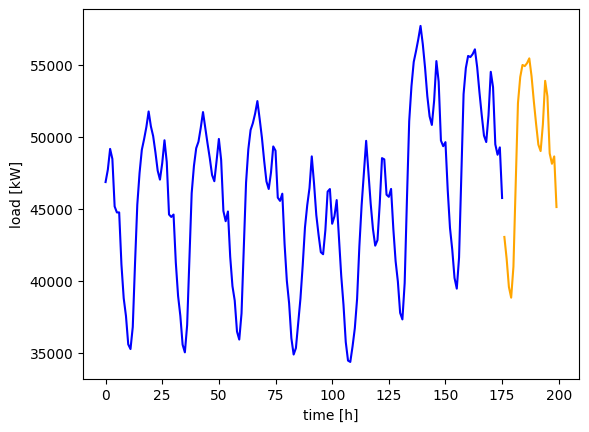

In [102]:
# Visualize the forecasts (blue=train, orange=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [103]:
df = pd.concat([test_ts.iloc[:, 0], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,43039.218878
2020-09-30 00:00:00,41540.0,41532.218878
2020-09-30 01:00:00,41540.0,39569.218878
2020-09-30 02:00:00,39396.0,38827.218878
2020-09-30 03:00:00,38846.0,40975.218878
2020-09-30 04:00:00,40910.0,46698.218878
2020-09-30 05:00:00,50996.0,52328.218878
2020-09-30 06:00:00,53301.0,54133.218878
2020-09-30 07:00:00,54210.0,54972.218878
2020-09-30 08:00:00,53978.0,54892.218878


In [105]:
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 0]))

1572.7596573287233

# Without exog

In [106]:
model1 = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=True, m=24, maxiter=3)
forecasts1, confidence = model1.predict(test_ts.shape[0], return_conf_int=True)

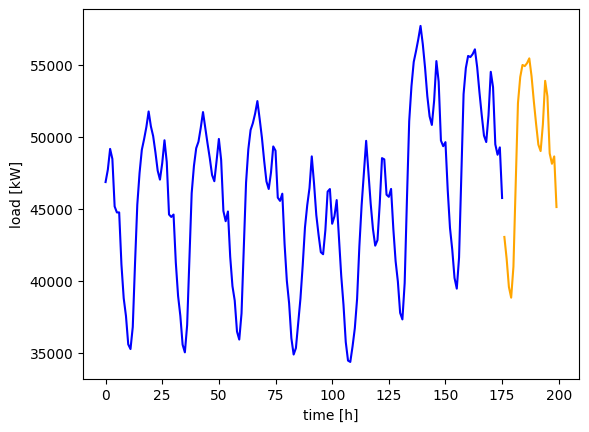

In [107]:
# Visualize the forecasts (blue=train, orange=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts1, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [108]:
df = pd.concat([test_ts.iloc[:, 0], forecasts1], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,43039.218878
2020-09-30 00:00:00,41540.0,41532.218878
2020-09-30 01:00:00,41540.0,39569.218878
2020-09-30 02:00:00,39396.0,38827.218878
2020-09-30 03:00:00,38846.0,40975.218878
2020-09-30 04:00:00,40910.0,46698.218878
2020-09-30 05:00:00,50996.0,52328.218878
2020-09-30 06:00:00,53301.0,54133.218878
2020-09-30 07:00:00,54210.0,54972.218878
2020-09-30 08:00:00,53978.0,54892.218878


In [109]:
np.sqrt(mean_squared_error(forecasts1, test_ts.iloc[:, 0]))

1572.7596573287233

In [110]:
forecasts1

2020-09-29 23:00:00    43039.218878
2020-09-30 00:00:00    41532.218878
2020-09-30 01:00:00    39569.218878
2020-09-30 02:00:00    38827.218878
2020-09-30 03:00:00    40975.218878
2020-09-30 04:00:00    46698.218878
2020-09-30 05:00:00    52328.218878
2020-09-30 06:00:00    54133.218878
2020-09-30 07:00:00    54972.218878
2020-09-30 08:00:00    54892.218878
2020-09-30 09:00:00    55093.218878
2020-09-30 10:00:00    55429.218878
2020-09-30 11:00:00    54187.218878
2020-09-30 12:00:00    52457.218878
2020-09-30 13:00:00    50881.218878
2020-09-30 14:00:00    49445.218878
2020-09-30 15:00:00    48996.218878
2020-09-30 16:00:00    50847.218878
2020-09-30 17:00:00    53870.218878
2020-09-30 18:00:00    52802.218878
2020-09-30 19:00:00    48835.218878
2020-09-30 20:00:00    48115.218878
2020-09-30 21:00:00    48628.218878
2020-09-30 22:00:00    45113.218878
Freq: H, dtype: float64

# Seasonal=False

In [111]:
model2 = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=False, maxiter=3)
forecasts2, confidence = model2.predict(test_ts.shape[0], return_conf_int=True)

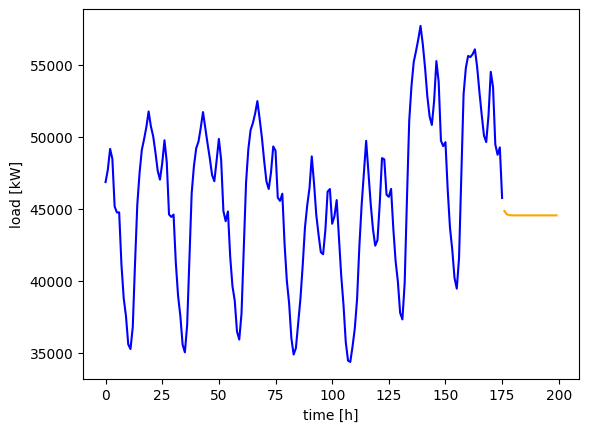

In [112]:
# Visualize the forecasts (blue=train, orange=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts2, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [113]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 0]))

6418.577666238862

# With m=24

In [165]:
# The period for seasonal differencing, m refers to the number of periods in each season.
# For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. 
# Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more 
#information on setting this parameter, see Setting m.


model = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=True, m=24, maxiter=3)
# model = pm.auto_arima(combined_data, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)
# Make a forecast for the current window
#forecast, conf_int = model.predict(n_periods=prediction_length, return_conf_int=True)
            

In [191]:
model.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(5, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 24),
      suppress_warnings=True)>

In [ ]:
updated_model = model.update(test_ts.iloc[:,0])

# Step 3: Forecast
forecast = updated_model.predict(n_periods=24)


In [192]:
model2.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(2, 0, 4), scoring_args={}, suppress_warnings=True)>

In [166]:
forecasts, confidence = model.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future

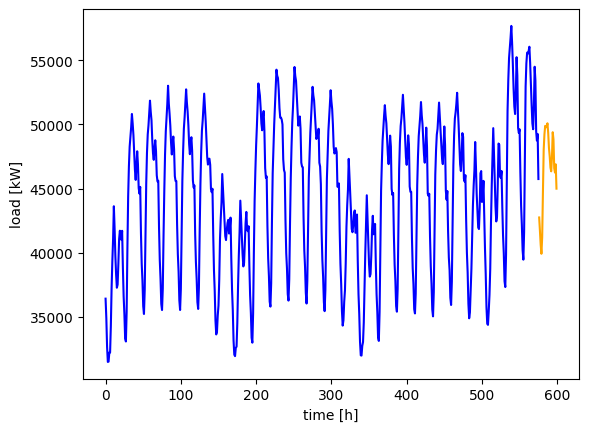

In [171]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

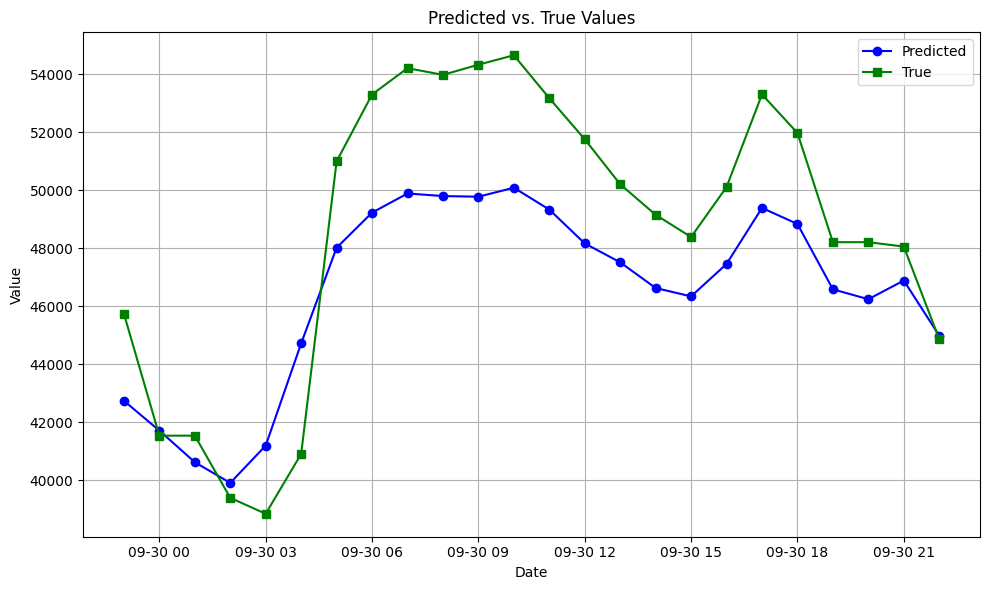

In [183]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(forecasts.index, forecasts, label='Predicted', color='blue', marker='o')  # Plot forecasted values
plt.plot(test_ts.index, test_ts.iloc[:, 0], label='True', color='green', marker='s')  # Plot true values
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Value')  # Set y-axis label
plt.title('Predicted vs. True Values')  # Set plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 0]))

3019.639899294806

In [177]:
mean_squared_error(forecasts, test_ts.iloc[:, 0])

9118225.121413147

In [182]:
df = pd.concat([test_ts.iloc[:, 0], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42742.864115
2020-09-30 00:00:00,41540.0,41714.253527
2020-09-30 01:00:00,41540.0,40623.920446
2020-09-30 02:00:00,39396.0,39911.586563
2020-09-30 03:00:00,38846.0,41196.632844
2020-09-30 04:00:00,40910.0,44720.466419
2020-09-30 05:00:00,50996.0,48019.339309
2020-09-30 06:00:00,53301.0,49228.363408
2020-09-30 07:00:00,54210.0,49888.553852
2020-09-30 08:00:00,53978.0,49799.933336


# Seasonal=False

In [184]:
# 2.1 sec??????
model2 = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=False, maxiter=3)

forecasts2, confidence2 = model2.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future


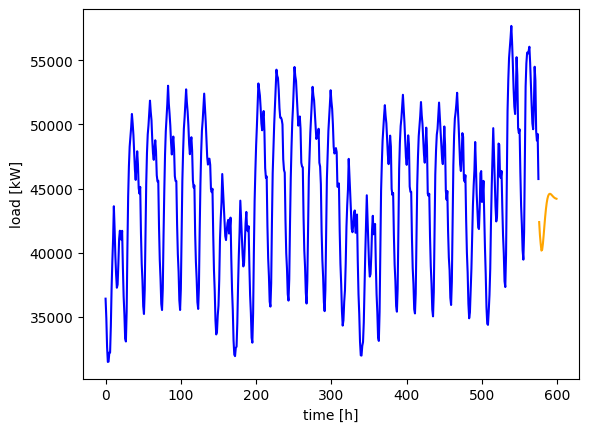

In [186]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts2, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [189]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 0]))

6780.192668328311

In [190]:
df = pd.concat([test_ts.iloc[:, 0], forecasts2], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42384.640177
2020-09-30 00:00:00,41540.0,41378.206071
2020-09-30 01:00:00,41540.0,40703.875271
2020-09-30 02:00:00,39396.0,40158.492307
2020-09-30 03:00:00,38846.0,40237.694983
2020-09-30 04:00:00,40910.0,40709.681417
2020-09-30 05:00:00,50996.0,41384.073128
2020-09-30 06:00:00,53301.0,42117.210937
2020-09-30 07:00:00,54210.0,42810.620243
2020-09-30 08:00:00,53978.0,43405.251377


In [42]:
# Study periods length
period_b = 0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250
period_e = 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250
# Split period into training, validation and test set
training_size = 750
test_size = 250

In [43]:
Results = pd.DataFrame(index = range(period_b[0], period_e[9] - training_size))
Results

""
0
1
2
3
4
...
2495
2496
2497
2498


In [44]:
for i in range(len(period_b)):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [47]:
24*83

1992

In [48]:
24*365

8760

In [45]:
1923536/400

4808.84

In [ ]:
5*3

In [ ]:
Results = pd.DataFrame(index = range(period_b[0], period_e[9] - training_size))# 2500
for i in range(len(period_b)): # 0, 9
    for j in range(len(Target_feature.columns)): # 35
        # 750 from 0
        training = Target_feature.iloc[period_b[i] : period_b[i] + training_size, j].to_list()
        # 250 from 0
        test = Target_feature.iloc[period_e[i] - test_size : period_e[i], j].reset_index(drop = True)
        exogenous = Exogenous[period_b[0] : period_b[0] + training_size]

        with np.errstate(divide='ignore'):
            arima_model = auto_arima(training, exogenous, start_p = 0, start_q = 0, seasonal = False)
        predictions = []
        for k in range(test_size):
            model = ARIMA(training, exogenous, order = arima_model.get_params().get("order"))
            model_fit = model.fit()
            predictions.append(model_fit.forecast(exog = Exogenous[k + training_size])[0])
            training.append(test[k])
            exogenous.append(Exogenous[k + training_size])
        Results.iloc[period_b[i] : period_b[i] + test_size, j] = predictions